# Imports and Definitions

In [1]:
import sys
sys.path.append('../')

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from utils.data_utils import preprocess_and_normalize_energy_data, parse_codecarbon_output
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from utils.experiments_utils import split_data_set, fit_model, compute_log_transformed_features, apply_data_transforms, test_model
%load_ext autoreload
%autoreload 2
SEED = 1234

In [3]:
param_cols = ['batch_size','input_size','output_size']
models = {}
estimates = {}

# Linear Module
## Load Data

In [4]:
d1 = parse_codecarbon_output(
    '../data/linear/00_linear-raw.csv',
    False,
    ('../data/linear/00_linear-slurm-log.out','linear',False,3)
)
print("dataset shape:", d1.shape)

Dropped observations with the following indices: [5, 80, 235, 275, 466, 470, 665, 697, 860, 926, 1054, 1158, 1249, 1443]
dataset shape: (1486, 28)


In [5]:
d2 = parse_codecarbon_output(
    '../data/linear/02_linear-raw.csv',
    False,
    ('../data/linear/02_linear-slurm-log.out','linear',True,3)
)
print("dataset shape:", d2.shape)

Dropped observations with the following indices: [66, 67, 68, 456, 457, 458, 624, 625, 626, 651, 652, 653, 855, 856, 857, 1086, 1087, 1088, 1236, 1237, 1238, 1428, 1429, 1430]
dataset shape: (1476, 28)


In [6]:
data_unnormalized = pd.concat([d1,d2])
print("dataset shape before aggregation: ", data_unnormalized.shape)
data = preprocess_and_normalize_energy_data(data_unnormalized, param_cols, aggregate=True)

dataset shape before aggregation:  (2962, 28)
Final shape of data set: (992, 19)


## Feature Set: Parameters

In [7]:
print(f"Used features: {param_cols}")
dfs = split_data_set(data, param_cols, SEED)
transformers_dict = {
    "x_preprocessors": [PolynomialFeatures(degree=3, interaction_only=True)],
    "y_preprocessor": MinMaxScaler()
}
dfs, _ = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(LinearRegression(), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

Used features: ['batch_size', 'input_size', 'output_size']
Average R2 Cross-Validation Score: 0.999 (± 0.000)
Average MSE Cross-Validation: -3.784e-05 (± 1.300e-05)
Validation R2 Score: 0.999
Validation MSE: 3.687e-05


Test R2 Score: 0.9990
Test MSE: 3.848e-05


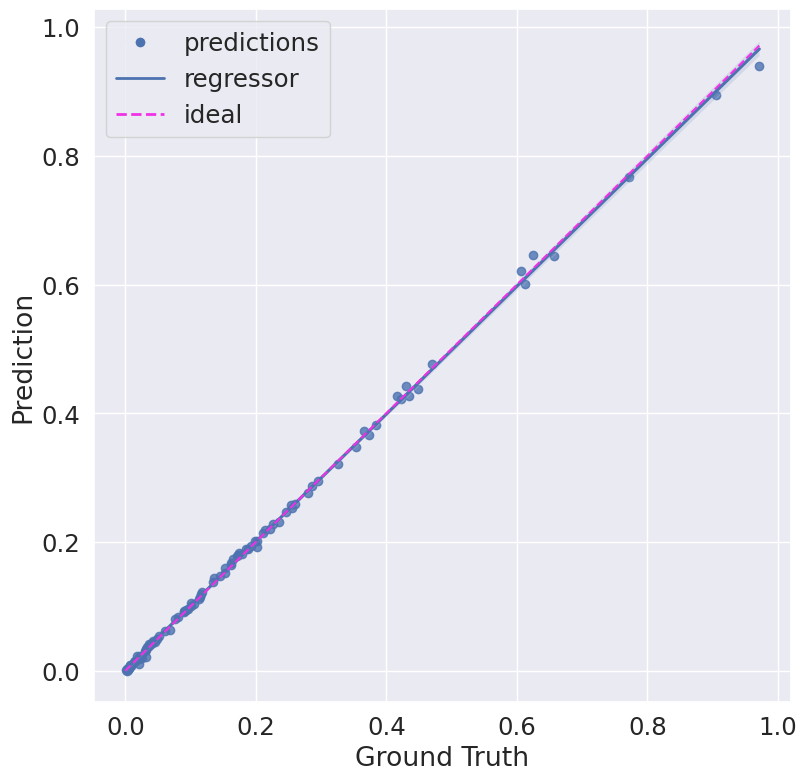

In [8]:
# test model
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

In [9]:
# save model & estimates
models['param'] = model
estimates['param'] = y_hat

### Notes
- Compared to the conv2d model, here a standard LinearRegressor without Polynomial Features performs reasonable well with a test R2 score of over 0.73
- but even with just second degree polynomials the score boosts to 0.97 on the validation and test-set.
- degree 3 boosts the score to 0.99, with MSE of two magnitudes smaller
- no benefit from allowing terms other than interaction_only

## Feature-Set: Module Parameters + Log-Parameters

In [10]:
data_linear_with_log, param_cols_with_log = compute_log_transformed_features(data, param_cols)
print(f"Used features: {param_cols_with_log}")
dfs = split_data_set(data_linear_with_log, param_cols_with_log, SEED)
transformers_dict = {
    "x_preprocessors": [PolynomialFeatures(degree=3, interaction_only=True)],
    "y_preprocessor": MinMaxScaler()
}
dfs, _ = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(LinearRegression(), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

Used features: ['batch_size', 'input_size', 'output_size', 'log_batch_size', 'log_input_size', 'log_output_size']
Average R2 Cross-Validation Score: 0.999 (± 0.000)
Average MSE Cross-Validation: -2.756e-05 (± 1.179e-05)
Validation R2 Score: 0.999
Validation MSE: 2.332e-05


Test R2 Score: 0.9995
Test MSE: 1.839e-05


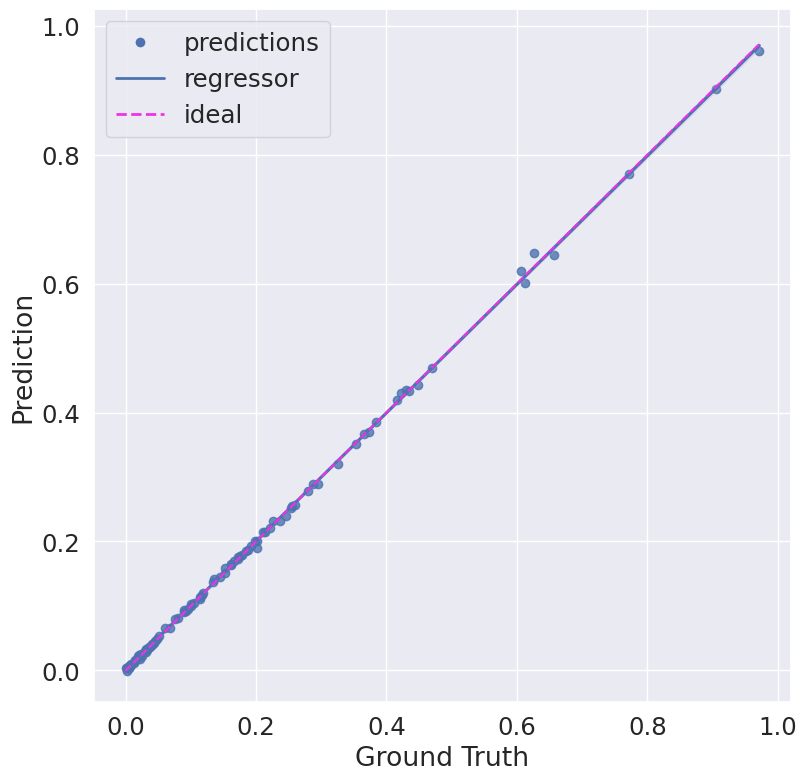

In [11]:
# test model
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

In [12]:
# save model & estimates
models['param_log_param'] = model
estimates['param_log_param'] = y_hat

### Notes
- adding log terms doesn't add any real improvement with just linear terms
- with degree 3 we achieve a perfect R2 score of 1.0 with a significant reduction in MSE
- no improvements with Lasso

## Feature-Set: MACs Only

In [13]:
dfs = split_data_set(data, ['macs'], SEED)
transformers_dict = {
    "x_preprocessors": None,
    "y_preprocessor": MinMaxScaler()
}
dfs, _ = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(LinearRegression(), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

Average R2 Cross-Validation Score: 0.999 (± 0.000)
Average MSE Cross-Validation: -4.284e-05 (± 1.425e-05)
Validation R2 Score: 0.999
Validation MSE: 3.730e-05


Test R2 Score: 0.9992
Test MSE: 3.384e-05


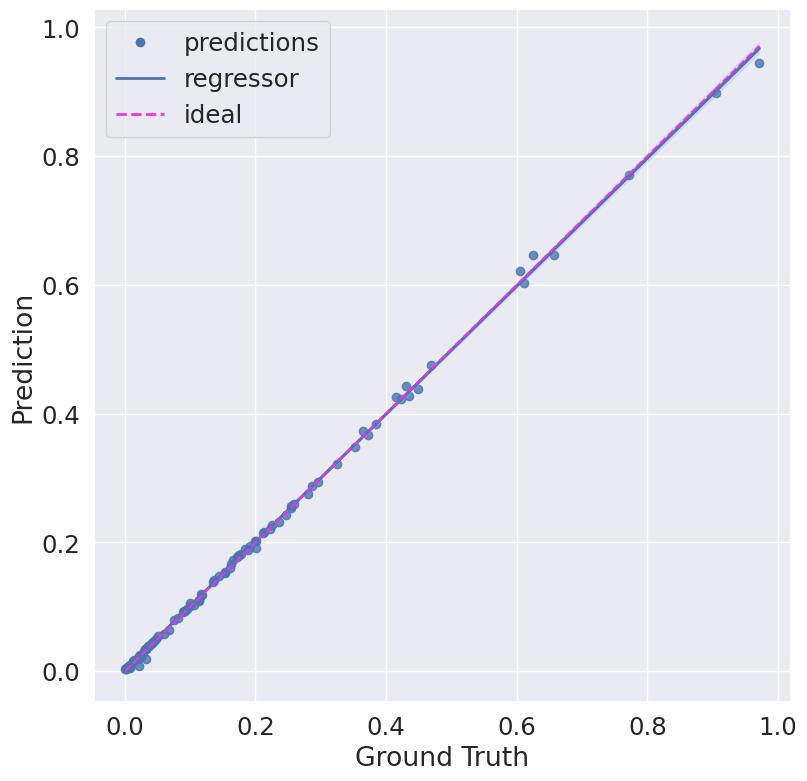

In [14]:
# test model
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

In [15]:
# save model & estimates
models['macs'] = model
estimates['macs'] = y_hat

### Notes
- out-of-the-box performance very good
- performs equally with param model with polynomial terms
- but MSE quite a bit larger compared to previous model, yet I believe the tradeoff is clear due to the simplicity of this model

# Feature-Set: Module Parameters + MACs

In [16]:
dfs = split_data_set(data, param_cols + ['macs'], SEED)
print(f"Used features: { param_cols + ['macs']}")
transformers_dict = {
    "x_preprocessors": [StandardScaler()],
    "y_preprocessor": MinMaxScaler()
}
dfs, _ = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(LinearRegression(), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

Used features: ['batch_size', 'input_size', 'output_size', 'macs']
Average R2 Cross-Validation Score: 0.999 (± 0.000)
Average MSE Cross-Validation: -3.909e-05 (± 1.313e-05)
Validation R2 Score: 0.999
Validation MSE: 3.635e-05


Test R2 Score: 0.9991
Test MSE: 3.693e-05


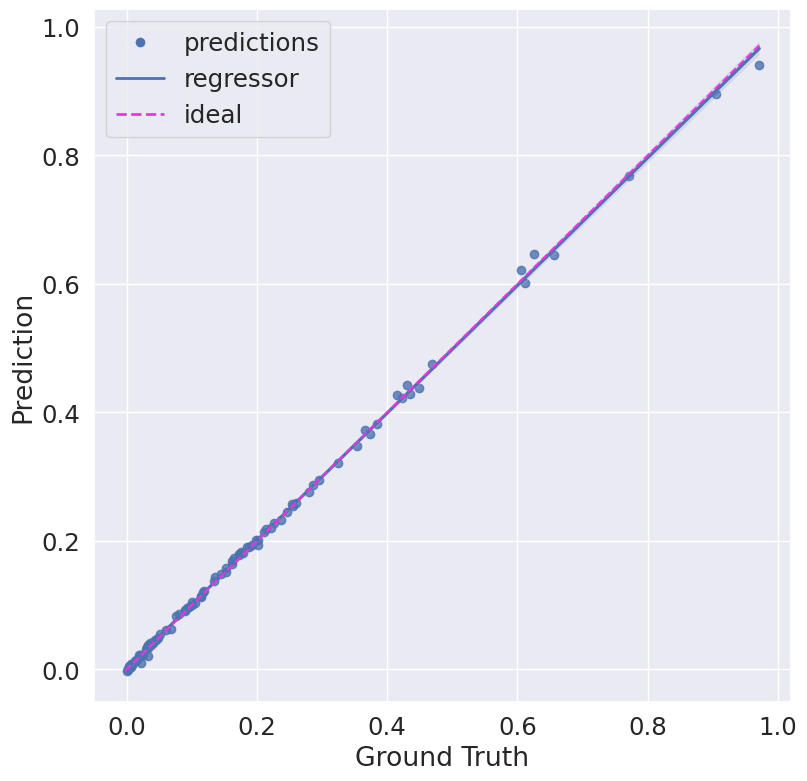

In [17]:
# test model
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

In [18]:
# save model & estimates
models['param_macs'] = model
estimates['param_macs'] = y_hat

### Notes
- no performance improvement over MACs only model
- can achieve 1.0 R2 with polynomial interaction only terms of degree 3, although with a higher MSE compared to param+log_param
- lasso provides no improvements here

## Feature-Set: Module Parameters + Log-Parameters + MACs

In [19]:
data_linear_with_log, param_cols_with_log = compute_log_transformed_features(data, param_cols)
print(f"Used features: {param_cols_with_log + ['macs']}")
dfs = split_data_set(data_linear_with_log, param_cols_with_log + ['macs'], SEED)
transformers_dict = {
    "x_preprocessors": [StandardScaler()],
    "y_preprocessor": MinMaxScaler()
}
dfs, _ = apply_data_transforms(dfs, transformers_dict)
model, *_ = fit_model(LinearRegression(), dfs["x_train"], dfs["y_train"], dfs["x_val"], dfs["y_val"], plot_results=False)

Used features: ['batch_size', 'input_size', 'output_size', 'log_batch_size', 'log_input_size', 'log_output_size', 'macs']
Average R2 Cross-Validation Score: 0.999 (± 0.000)
Average MSE Cross-Validation: -3.466e-05 (± 1.147e-05)
Validation R2 Score: 0.999
Validation MSE: 3.250e-05


Test R2 Score: 0.9992
Test MSE: 3.134e-05


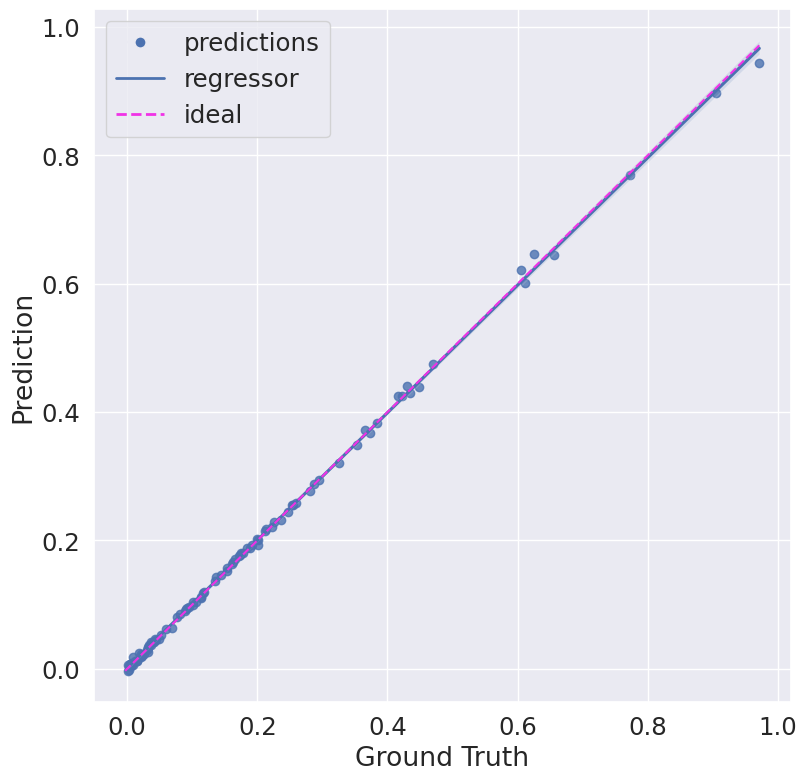

In [20]:
# test model
y_hat, *_ = test_model(model,dfs["x_test"],dfs["y_test"],plot_results=True)

In [21]:
# save model & estimates
models['param_log_param_macs'] = model
estimates['param_log_param_macs'] = y_hat

### Notes
- no improvement yielded by this configuration over previous ones

# Comparison of all models

param                               0.999
param_log_param                     1.0
macs                                0.999
param_macs                          0.999
param_log_param_macs                0.999


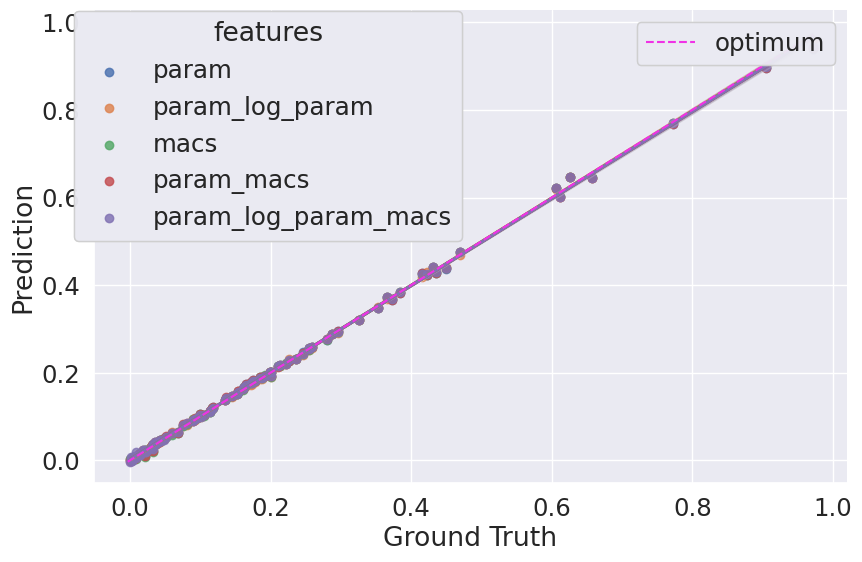

In [22]:
df_to_plot = pd.DataFrame(columns=["features","y_hat",'y'])
for model_name, model in models.items():
    new_df = pd.DataFrame(data={'features':[model_name]*len(dfs['y_test']),'y_hat':np.squeeze(estimates[model_name]),'y':np.squeeze(dfs['y_test'])})
    df_to_plot = pd.concat([df_to_plot, new_df], ignore_index=True)
    print(f"{'{:<35}'.format(model_name)} {round(r2_score(dfs['y_test'], estimates[model_name]), 3)}")
min_x = min(min(df_to_plot.y_hat),min(df_to_plot.y))
max_x = max(max(df_to_plot.y_hat),max(df_to_plot.y))
g = sns.lmplot(data=df_to_plot, x="y", y="y_hat", hue="features", ci=95, height=6, aspect=1.5, facet_kws={'legend_out':False}, markers='o')
plt.plot([min_x, max_x], [min_x, max_x],ls='--', marker='', label='optimum', color="#f032e6")
line = Line2D([0], [0], ls='--', label='optimum', color='#f032e6')
g.set(xlabel='Ground Truth', ylabel='Prediction')
sns.move_legend(g, "upper left", bbox_to_anchor=(.09, .97))
legend1 = g.legend
legend2 = plt.legend(handles = [plt.plot([],ls="--", color=line.get_color())[0]], labels=[line.get_label()], loc='upper right')
g.fig.add_artist(legend1)
g.fig.add_artist(legend2)